In [ ]:
!pip install pertpy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 627.0/627.0 kB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.9/291.9 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 78.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.6/183.6 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 560.6/560.6 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.4/172.4 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 824.2/824.2 kB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 7.5 MB/s eta 0:00

In [ ]:
# --- Standard-library utilities ------------------------------------------------
import os                 # file-system operations (e.g. os.environ or os.path)
import sys                # Python runtime details; we use it for version checks
import time               # simple timing / benchmarking of cells
from pathlib import Path  # convenient, cross-platform path handling
from collections import OrderedDict  # deterministic dicts for reproducible logs
import random             # Python RNG (seeded below for reproducibility)
import warnings           # warning control (e.g. to suppress scVI warnings)
import gdown              # enable google drive downloads
warnings.filterwarnings('ignore')  # suppress warnings (e.g. from scVI or scanpy)

# --- Numerical & data-handling stack -------------------------------------------
import numpy as np        # dense numerical arrays
import pandas as pd       # tabular data frames
from pandas.api.types import CategoricalDtype  # categorical data types
from scipy import sparse  # sparse matrix utilities
from scipy import stats   # statistical functions (e.g. t-tests, correlations)
from scipy.spatial.distance import cosine as cosine_dist, cdist  # distance metrics
from scipy.sparse import issparse  # check if a matrix is sparse

# --- Single-cell analysis ecosystem --------------------------------------------
import scanpy as sc       # core single-cell workflow (AnnData, QC, plotting)
from scanpy.pl import DotPlot # dot plots for visualising gene expression
import anndata            # core data structure for single-cell data (AnnData)
import pertpy as pt       # Perturb-Bench helpers: dataset loaders & metrics
import scvi               # single-cell variational inference (scVI) for deep learning
from scvi import REGISTRY_KEYS  # keys used by scvi-tools / scGen for AnnData metadata

# --- Deep-learning backend -----------------------------------------------------
import torch                    # PyTorch (Tensor operations)
import pytorch_lightning as pl  # PyTorch Lightning (high-level training framework)

# --- Machine-learning utilities ------------------------------------------------
from sklearn.decomposition import PCA                # dimensionality reduction
from sklearn.neighbors import KernelDensity          # density estimation
from sklearn.metrics import r2_score                 # R-squared metric
from sklearn.metrics import pairwise_distances       # pairwise distance metrics

# --- Plotting & visualisation --------------------------------------------------
import matplotlib.pyplot as plt  # base plotting library
import matplotlib as mpl         # base matplotlib library
import seaborn as sns            # higher-level statistical plots

# --- Device & runtime configuration --------------------------------------------
device = torch.device("cuda")
print(f"Running on'GPU'")

# --- Global reproducibility ----------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True   # exact determinism (may reduce speed)
torch.backends.cudnn.benchmark = False
pl.seed_everything(SEED, workers=True)
scvi.settings.seed = SEED

print(f"Random seed set to {SEED}")

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Running on'GPU'
Random seed set to 42


In [ ]:
adata = pt.dt.tian_2019_day7neuron()
adata

Output()

AnnData object with n_obs × n_vars = 182790 × 33752
    obs: 'batch', 'cancer', 'celltype', 'disease', 'guide_id', 'organism', 'perturbation', 'perturbation_type', 'sgRNA_read_count', 'sgRNA_umi_count', 'tissue_type', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'percent_hemo'
    var: 'ensemble_id', 'ncounts', 'ncells'

In [ ]:
perturbation_counts = adata.obs['perturbation'].value_counts().reset_index()
perturbation_counts.columns = ['perturbation', 'cell_count']

In [ ]:
perturbation_counts.head(60)

perturbation  cell_count
0                   MAT2A       21895
1                 control       15580
2                    UBA1       10158
3                   RAB7A        5732
4                 MAP3K12        5144
5                 PPP2R1A        4222
6              UBA1_MAT2A        3306
7                     RFK        3289
8                    MMAB        2991
9                   HACD2        2088
10                  UQCRQ        1870
11                  PPCDC        1869
12            RAB7A_MAT2A        1646
13                   UROD        1628
14                    MVK        1613
15          PPP2R1A_MAT2A        1589
16          MAP3K12_MAT2A        1410
17                   FECH        1015
18              RFK_MAT2A         888
19             MMAB_MAT2A         869
20                   SQLE         848
21                   PMVK         811
22                 PPP1R8         781
23                 PGGT1B         718
24           MAP3K12_UBA1         632
25             UBA1_RAB7A         600
26            PPCDC_MAT2A         568
27     MAP3K12_UBA1_MAT2A         561
28            HACD2_MAT2A         543
29             UROD_MAT2A         537
30            UQCRQ_MAT2A         529
31                 HMGCS1         518
32              MVK_MAT2A         495
33                 ATP5A1         457
34       UBA1_RAB7A_MAT2A         449
35           UBA1_PPP2R1A         437
36                  KIF1A         414
37                    LSS         384
38     UBA1_PPP2R1A_MAT2A         380
39                SEPSECS         364
40               UBA1_RFK         363
41         UBA1_RFK_MAT2A         329
42          MAP3K12_RAB7A         328
43             FECH_MAT2A         287
44                    GSR         271
45             UBA1_UQCRQ         269
46        MAP3K12_PPP2R1A         269
47                 NDUFA1         266
48    MAP3K12_RAB7A_MAT2A         258
49              UROD_UBA1         242
50          PPP2R1A_RAB7A         240
51  MAP3K12_PPP2R1A_MAT2A         239
52             SQLE_MAT2A         230
53              UBA1_MMAB         223
54             PMVK_MAT2A         221
55             PPCDC_UBA1         216
56               MVK_UBA1         208
57              RAB7A_RFK         207
58           PPP2R1A_UBA1         201
59         MVK_UBA1_MAT2A         200

In [ ]:
# List of genes
target_genes = ["PGGT1B", "SEPSECS", "NDUFA1"]

# Dictionary to store the new adata objects
gene_adata_dict = {}

for gene in target_genes:
    # Filter for cells where perturbation is either the gene or 'control'
    mask = adata.obs["perturbation"].isin([gene, "control"])
    gene_adata_dict[gene] = adata[mask].copy()

In [ ]:
train = gene_adata_dict["NDUFA1"]
train.obs["perturbation"].unique()

['control', 'NDUFA1']
Categories (2, object): ['NDUFA1', 'control']

In [ ]:
print(train.X)

<Compressed Sparse Column sparse matrix of dtype 'float32'
	with 3734388 stored elements and shape (15846, 33752)>
  Coords	Values
  (1276, 3)	1.0
  (1338, 3)	1.0
  (7901, 3)	1.0
  (10042, 3)	1.0
  (10266, 3)	1.0
  (11387, 3)	1.0
  (13140, 3)	1.0
  (15775, 3)	1.0
  (4, 8)	1.0
  (102, 8)	1.0
  (207, 8)	1.0
  (313, 8)	1.0
  (661, 8)	1.0
  (739, 8)	1.0
  (945, 8)	1.0
  (1020, 8)	1.0
  (1056, 8)	1.0
  (1100, 8)	1.0
  (1276, 8)	1.0
  (1297, 8)	1.0
  (1306, 8)	1.0
  (1582, 8)	1.0
  (1591, 8)	1.0
  (1719, 8)	1.0
  (2127, 8)	1.0
  :	:
  (15305, 33751)	1.0
  (15325, 33751)	1.0
  (15347, 33751)	2.0
  (15362, 33751)	2.0
  (15376, 33751)	1.0
  (15385, 33751)	1.0
  (15428, 33751)	1.0
  (15462, 33751)	1.0
  (15506, 33751)	1.0
  (15535, 33751)	1.0
  (15539, 33751)	1.0
  (15590, 33751)	1.0
  (15597, 33751)	1.0
  (15605, 33751)	1.0
  (15616, 33751)	1.0
  (15637, 33751)	1.0
  (15639, 33751)	1.0
  (15649, 33751)	1.0
  (15662, 33751)	1.0
  (15671, 33751)	1.0
  (15686, 33751)	1.0
  (15732, 33751)	2.0
  (15

In [ ]:
sc.pp.pca(train)

In [ ]:
sc.pp.neighbors(train)
sc.tl.umap(train)

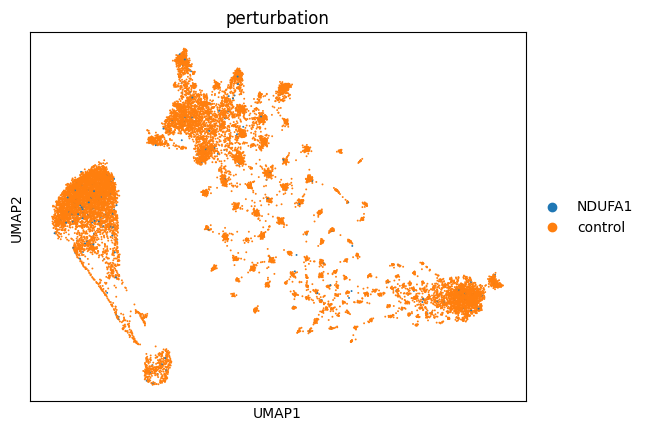

In [ ]:
sc.pl.umap(train, color = 'perturbation')
fig = plt.gcf()
display(fig)

In [ ]:
train.obs['cell_type'] = 'neurons'

In [ ]:
train

AnnData object with n_obs × n_vars = 15846 × 33752
    obs: 'batch', 'cancer', 'celltype', 'disease', 'guide_id', 'organism', 'perturbation', 'perturbation_type', 'sgRNA_read_count', 'sgRNA_umi_count', 'tissue_type', 'nperts', 'ngenes', 'ncounts', 'percent_mito', 'percent_ribo', 'percent_hemo', 'cell_type'
    var: 'ensemble_id', 'ncounts', 'ncells'
    uns: 'pca', 'neighbors', 'umap', 'perturbation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
sc.pp.normalize_total(train, target_sum=1e4)
sc.pp.log1p(train)


sc.pp.highly_variable_genes(train,
                            n_top_genes=4000,
                            subset=True)

In [ ]:
print(train.X)

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 784665 stored elements and shape (15846, 4000)>
  Coords	Values
  (0, 559)	4.823958396911621
  (0, 574)	4.823958396911621
  (0, 1012)	4.823958396911621
  (0, 1625)	4.823958396911621
  (0, 1720)	4.823958396911621
  (0, 2095)	4.823958396911621
  (0, 2156)	4.823958396911621
  (0, 2217)	4.823958396911621
  (0, 2628)	4.823958396911621
  (0, 2633)	4.823958396911621
  (0, 2933)	4.823958396911621
  (0, 2979)	4.823958396911621
  (0, 3204)	4.823958396911621
  (0, 3392)	4.823958396911621
  (0, 3997)	4.823958396911621
  (1, 35)	7.601402282714844
  (1, 3905)	7.601402282714844
  (2, 2156)	7.824445724487305
  (3, 193)	7.265130043029785
  (3, 2181)	7.265130043029785
  (3, 2754)	7.265130043029785
  (4, 2)	0.7657233476638794
  (4, 11)	0.4544296860694885
  (4, 17)	0.4544296860694885
  (4, 19)	0.4544296860694885
  :	:
  (15843, 3885)	3.1886563301086426
  (15843, 3973)	3.1886563301086426
  (15843, 3984)	3.1886563301086426
  (15843, 3988)	4.54354

In [ ]:
pt.tl.Scgen.setup_anndata(train, batch_key="perturbation", labels_key="cell_type")


In [ ]:
print(train.obs.columns)
# Should include: _scgen_batch, _scgen_labels


Index(['batch', 'cancer', 'celltype', 'disease', 'guide_id', 'organism',
       'perturbation', 'perturbation_type', 'sgRNA_read_count',
       'sgRNA_umi_count', 'tissue_type', 'nperts', 'ngenes', 'ncounts',
       'percent_mito', 'percent_ribo', 'percent_hemo', 'cell_type',
       '_scvi_batch', '_scvi_labels'],
      dtype='object')


In [ ]:
# pt.tl.Scgen.setup_anndata(train, batch_key="perturbation", labels_key="cell_type")

# Train the model on the subsetted train data
new_model = pt.tl.Scgen(train)

# this step is necessary if your target dataset has more cell types than your training dataset
# new_model._register_manager_for_instance(new_model.adata_manager.transfer_fields(adata_target=query_CTRL, extend_categories=True))

# We'll have to tune the hyperparameters in the end: Max epoch = 100, change batch size
new_model.train(
    max_epochs=100,
    batch_size=32,
    early_stopping=True,
    early_stopping_patience=25,
    accelerator="cuda",  # 'cuda' means you call GPU, otherwise default value is 'cpu'
)

INFO     Jax module moved to cuda:0.Note: Pytorch lightning will show GPU is not being used for the Trainer.       


INFO: GPU available: True (cuda), used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 407.397. Signaling Trainer to stop.


In [ ]:
print(new_model.history.keys())

dict_keys(['train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])


In [ ]:
import matplotlib.pyplot as plt

def plot_scgen_diagnostics(model):
    history = model.history
    n_epochs = len(history["train_loss_epoch"])
    x = range(n_epochs)

    fig, axes = plt.subplots(3, 2, figsize=(12, 10))
    axes = axes.flatten()

    # 1. Total Loss
    axes[0].plot(x, history["train_loss_epoch"], label="Train")
    axes[0].plot(x, history["validation_loss"], label="Validation")
    axes[0].set_title("Loss")
    axes[0].legend()
    axes[0].grid(True)

    # 2. ELBO
    axes[1].plot(x, history["elbo_train"], label="Train")
    axes[1].plot(x, history["elbo_validation"], label="Validation")
    axes[1].set_title("ELBO")
    axes[1].legend()
    axes[1].grid(True)

    # 3. Reconstruction loss
    axes[2].plot(x, history["reconstruction_loss_train"], label="Train")
    axes[2].plot(x, history["reconstruction_loss_validation"], label="Validation")
    axes[2].set_title("Reconstruction Loss")
    axes[2].legend()
    axes[2].grid(True)

    # 4. KL local
    axes[3].plot(x, history["kl_local_train"], label="Train")
    axes[3].plot(x, history["kl_local_validation"], label="Validation")
    axes[3].set_title("KL Local")
    axes[3].legend()
    axes[3].grid(True)

    # 5. KL global
    axes[4].plot(x, history["kl_global_train"], label="Train")
    axes[4].plot(x, history["kl_global_validation"], label="Validation")
    axes[4].set_title("KL Global")
    axes[4].legend()
    axes[4].grid(True)

    # 6. Placeholder (or any extra)
    axes[5].axis('off')

    plt.tight_layout()
    plt.suptitle("scGen Training Diagnostics", y=1.02, fontsize=16)
    fig = plt.gcf()
    display(fig)


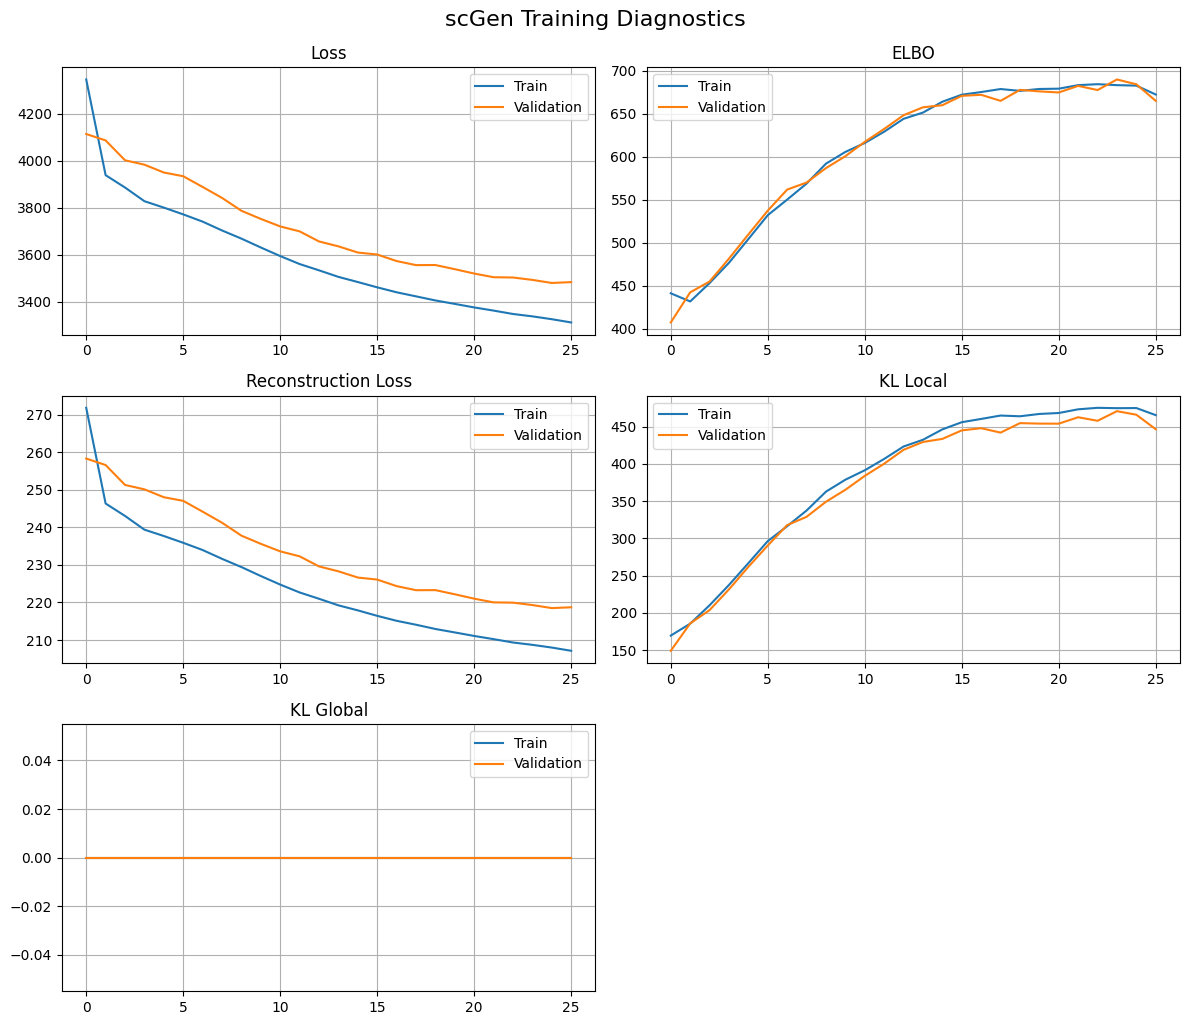

In [ ]:
plot_scgen_diagnostics(new_model)

In [ ]:
# Check all keys that are registered in the model
print(new_model.adata_manager.registry.keys())


dict_keys(['scvi_version', 'model_name', 'setup_args', 'field_registries', 'setup_method_name', '_scvi_uuid'])


In [ ]:
print(train.obs.columns)

Index(['batch', 'cancer', 'celltype', 'disease', 'guide_id', 'organism',
       'perturbation', 'perturbation_type', 'sgRNA_read_count',
       'sgRNA_umi_count', 'tissue_type', 'nperts', 'ngenes', 'ncounts',
       'percent_mito', 'percent_ribo', 'percent_hemo', 'cell_type',
       '_scvi_batch', '_scvi_labels'],
      dtype='object')


In [ ]:
# Healthy midbrain organoids from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM7732411

import gdown

# Google Drive file ID
file_id = "1zMTxq3qfDFLL8jgAbwNnsxMcRZlKtha1"
gdown.download(f"https://drive.google.com/uc?id={file_id}", output="midbrain_organoids_GSM7732411.h5ad", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1zMTxq3qfDFLL8jgAbwNnsxMcRZlKtha1
From (redirected): https://drive.google.com/uc?id=1zMTxq3qfDFLL8jgAbwNnsxMcRZlKtha1&confirm=t&uuid=e5a67eb2-cf38-48ac-9b6b-b41c5b9ff838
To: /content/midbrain_organoids_GSM7732411.h5ad
100%|██████████| 1.42G/1.42G [00:25<00:00, 55.7MB/s]


'midbrain_organoids_GSM7732411.h5ad'

In [ ]:
organoid = sc.read("midbrain_organoids_GSM7732411.h5ad")
organoid

AnnData object with n_obs × n_vars = 5978 × 19193
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'pearson_residuals_normalization', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'pearson_residuals', 'raw', 'sqrt

In [ ]:
organoid.var['gene_ids'].unique()

array(['ENSG00000227232', 'ENSG00000238009', 'ENSG00000268903', ...,
       'ENSG00000198727', 'ENSG00000210195', 'ENSG00000210196'],
      dtype=object)

In [ ]:
organoid.obs

n_genes_by_counts  log1p_n_genes_by_counts  \
AACACACAGAACGCTAGTACTATCGCC                230                 5.442418   
AACACACAGAACGCTAGTCCATCCTAA                215                 5.375278   
AACACACAGAACGTCCAACCATCCTAA                251                 5.529429   
AACACACAGAACGTCCAACTCTGCTTA                219                 5.393628   
AACACACAGAACGTCCAACTGCGTAGT                400                 5.993961   
...                                        ...                      ...   
TGTGGACACTGGTCAGTTACTGAAGCA                218                 5.389072   
TGTGGACACTGTCGGTGTGACTAACGG                304                 5.720312   
TGTGGACACTTCCAATCGATGAGTCCT                302                 5.713733   
TGTGGACACTTCGAGGATTCTCCAGAT                204                 5.323010   
TGTGGACACTTGCCGTCAACGTCCATA                241                 5.488938   

                             total_counts  log1p_total_counts  \
AACACACAGAACGCTAGTACTATCGCC         316.0            5.758902   
AACACACAGAACGCTAGTCCATCCTAA         479.0            6.173786   
AACACACAGAACGTCCAACCATCCTAA         339.0            5.828946   
AACACACAGAACGTCCAACTCTGCTTA         298.0            5.700444   
AACACACAGAACGTCCAACTGCGTAGT         614.0            6.421622   
...                                   ...                 ...   
TGTGGACACTGGTCAGTTACTGAAGCA         310.0            5.739793   
TGTGGACACTGTCGGTGTGACTAACGG         392.0            5.973810   
TGTGGACACTTCCAATCGATGAGTCCT         445.0            6.100319   
TGTGGACACTTCGAGGATTCTCCAGAT         318.0            5.765191   
TGTGGACACTTGCCGTCAACGTCCATA         308.0            5.733341   

                             pct_counts_in_top_50_genes  \
AACACACAGAACGCTAGTACTATCGCC                   43.037975   
AACACACAGAACGCTAGTCCATCCTAA                   65.553236   
AACACACAGAACGTCCAACCATCCTAA                   40.707965   
AACACACAGAACGTCCAACTCTGCTTA                   43.288591   
AACACACAGAACGTCCAACTGCGTAGT                   35.830619   
...                                                 ...   
TGTGGACACTGGTCAGTTACTGAAGCA                   45.806452   
TGTGGACACTGTCGGTGTGACTAACGG                   33.928571   
TGTGGACACTTCCAATCGATGAGTCCT                   37.752809   
TGTGGACACTTCGAGGATTCTCCAGAT                   51.572327   
TGTGGACACTTGCCGTCAACGTCCATA                   37.987013   

                             pct_counts_in_top_100_genes  \
AACACACAGAACGCTAGTACTATCGCC                    58.860759   
AACACACAGAACGCTAGTCCATCCTAA                    75.991649   
AACACACAGAACGTCCAACCATCCTAA                    55.457227   
AACACACAGAACGTCCAACTCTGCTTA                    60.067114   
AACACACAGAACGTCCAACTGCGTAGT                    51.140065   
...                                                  ...   
TGTGGACACTGGTCAGTTACTGAAGCA                    61.935484   
TGTGGACACTGTCGGTGTGACTAACGG                    47.959184   
TGTGGACACTTCCAATCGATGAGTCCT                    54.606742   
TGTGGACACTTCGAGGATTCTCCAGAT                    67.295597   
TGTGGACACTTGCCGTCAACGTCCATA                    54.220779   

                             pct_counts_in_top_200_genes  \
AACACACAGAACGCTAGTACTATCGCC                    90.506329   
AACACACAGAACGCTAGTCCATCCTAA                    96.868476   
AACACACAGAACGTCCAACCATCCTAA                    84.955752   
AACACACAGAACGTCCAACTCTGCTTA                    93.624161   
AACACACAGAACGTCCAACTGCGTAGT                    67.426710   
...                                                  ...   
TGTGGACACTGGTCAGTTACTGAAGCA                    94.193548   
TGTGGACACTGTCGGTGTGACTAACGG                    73.469388   
TGTGGACACTTCCAATCGATGAGTCCT                    77.078652   
TGTGGACACTTCGAGGATTCTCCAGAT                    98.742138   
TGTGGACACTTGCCGTCAACGTCCATA                    86.688312   

                             pct_counts_in_top_500_genes  total_counts_mt  \
AACACACAGAACGCTAGTACTATCGCC                        100.0              4.0   
AACACACAGAACGCTAGTCCATCCTAA               

In [ ]:
# Testing dataset
organoid = sc.read("midbrain_organoids_GSM7732411.h5ad")
organoid

# Replace X with raw counts stored in the 'raw' layer
organoid.X = organoid.layers["raw"].copy()

organoid.obs['cell_type'] = 'neurons'
organoid.obs['perturbation'] = 'control'

In [ ]:
# Normalize, log-transform, and find highly variable genes
sc.pp.normalize_total(organoid, target_sum=1e4)
sc.pp.log1p(organoid)


sc.pp.highly_variable_genes(organoid,
                            n_top_genes=4000,
                            subset=True)

In [ ]:
organoid

AnnData object with n_obs × n_vars = 5978 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden', 'cell_type', 'perturbation'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'means', 'variances', 'residual_variances', 'highly_variable_rank', 'highly_variable', 'dispersions', 'dispersions_norm'
    uns: 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'pearson_residuals_normalization', 'umap', 'log1p'
    obsm: 'X_pca'

In [ ]:
pred, delta = new_model.predict(ctrl_key="control", stim_key="NDUFA1", adata_to_predict=organoid)
pred.obs["perturbation"] = "pred"

INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Received view of anndata, making copy.                                                                    
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [ ]:
pred.X

array([[ 1.5112886e-02,  2.2469433e-03,  5.1853988e-02, ...,
         7.9430640e-02,  2.2914803e-02,  1.9205654e-02],
       [ 8.3300825e-03,  3.5524284e-03,  4.7580313e-02, ...,
         7.4099869e-02,  2.1167584e-02,  1.9436646e-02],
       [ 1.1964019e-02,  2.7143937e-03,  3.2978434e-02, ...,
         6.5727249e-02,  2.2162251e-02,  1.6465420e-02],
       ...,
       [ 9.9760089e-03,  1.5738555e-03,  3.0037899e-02, ...,
         6.6734120e-02,  2.3324007e-02,  1.5862055e-02],
       [ 2.9772348e-03, -1.5969602e-03, -2.9006191e-03, ...,
         5.2847557e-02,  1.9494776e-02,  1.5372536e-02],
       [ 1.6908577e-02,  6.4163469e-05,  5.6036565e-02, ...,
         1.2197888e-01,  4.6936028e-02,  2.2470945e-02]], dtype=float32)

In [ ]:
eval_adata = organoid.concatenate(pred)

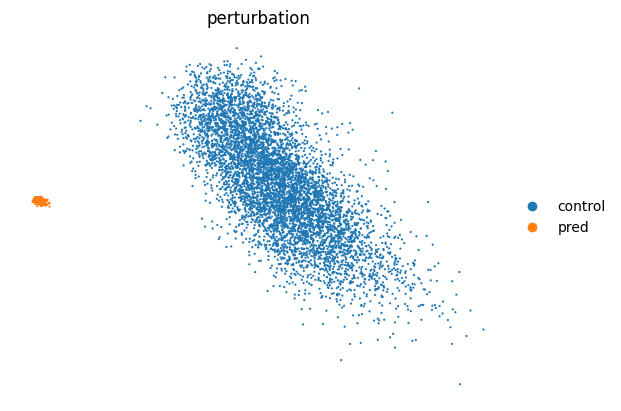

In [ ]:
sc.tl.pca(eval_adata)
sc.pl.pca(
    eval_adata,
    color="perturbation",
    frameon=False,
)
fig = plt.gcf()
display(fig)

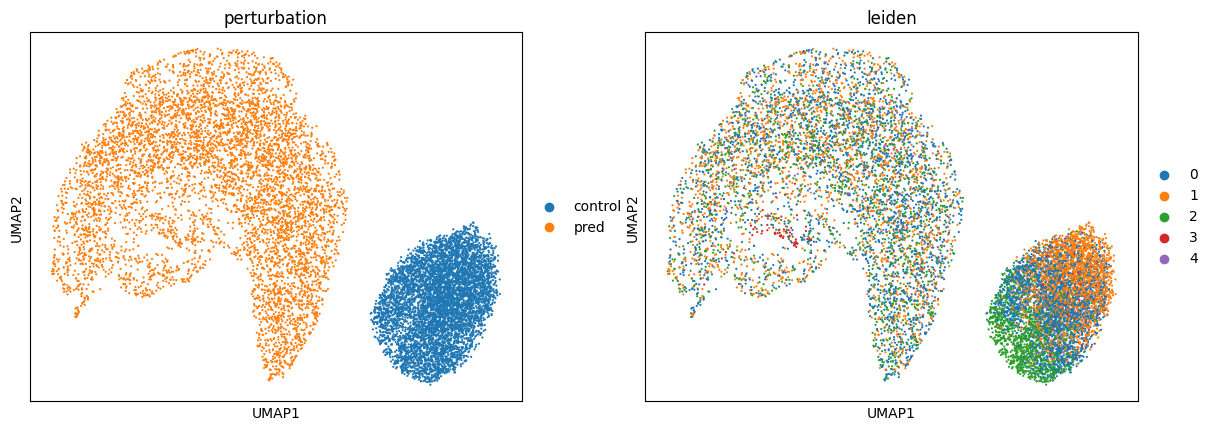

In [ ]:
sc.pp.neighbors(eval_adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(eval_adata)

sc.pl.umap(
    eval_adata,
    color=["perturbation", "leiden"]
)
fig = plt.gcf()
display(fig)

In [ ]:
obs_key = 'perturbation'
contrast = "control"

etest = pt.tl.DistanceTest("edistance", n_perms=100, obsm_key="X_pca", alpha=0.05)
tab = etest(eval_adata, groupby=obs_key, contrast=contrast)

Output()

In [ ]:
tab

distance  pvalue  significant  pvalue_adj  significant_adj
control   0.000000    1.00        False      1.0000            False
pred     14.058246    0.01         True      0.0199             True

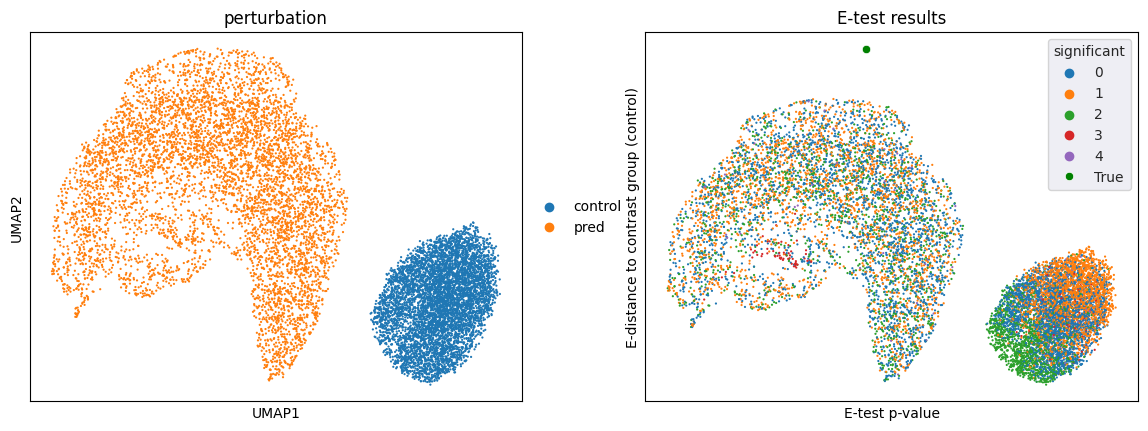

In [ ]:
import seaborn as sns

with sns.axes_style("darkgrid"):
    sns.scatterplot(
        data=tab[tab.index != contrast],
        x="pvalue",
        y="distance",
        hue="significant",
        palette={True: "green", False: "red"},
    )
plt.title("E-test results")
plt.xlabel("E-test p-value")
plt.ylabel("E-distance to contrast group (control)")
fig = plt.gcf()
display(fig)

In [ ]:
sc.tl.rank_genes_groups(eval_adata, groupby="perturbation", method="wilcoxon")
diff_genes = eval_adata.uns["rank_genes_groups"]["names"]
print(diff_genes)

[('MALAT1', 'NPFFR2') ('RRP12', 'AC007450.4') ('ZBTB45', 'AC026336.2') ...
 ('NPFFR2', 'ZBTB45') ('AC007450.4', 'RRP12') ('AC026336.2', 'MALAT1')]


In [ ]:
import scanpy as sc

# This gives you a tidy dataframe with gene names, scores, logFC, pvals, pvals_adj etc.
df = sc.get.rank_genes_groups_df(eval_adata, group=None)  # group=None returns all groups
print(df.head())

     group       names     scores  logfoldchanges  pvals  pvals_adj
0  control      MALAT1  94.658775       14.649422    0.0        0.0
1  control       RRP12  91.660545             NaN    0.0        0.0
2  control      ZBTB45  89.733231             NaN    0.0        0.0
3  control        PYGB  89.534401             NaN    0.0        0.0
4  control  AC008438.2  88.529297             NaN    0.0        0.0


In [ ]:
# Get the top 30 rows sorted by logFC (or adjust sorting if already sorted)
top_genes = df.sort_values("logfoldchanges", ascending=False).head(100)["names"].tolist()

print(top_genes)

['MALAT1', 'SACS', 'LINC01004', 'DMXL2', 'SELENOF', 'TENM2', 'CDH10', 'NDE1', 'AC244517.10', 'VAMP8', 'PHF6', 'MACROD2', 'SNAP91', 'SACM1L', 'GDPD1', 'FBXL17', 'NTM', 'STAG2', 'HECW1', 'SRI', 'AC120193.1', 'KCNQ1OT1', 'UNC5C', 'MIR4435-2HG', 'FGF14', 'AC087564.1', 'SNHG14', 'RBFOX1', 'PCDH9', 'THSD4', 'CRH', 'ROBO1', 'GRM7', 'TENM3', 'MT-RNR1', 'AL139383.1', 'GPBP1', 'AC090568.2', 'TRIAP1', 'CNTNAP4', 'CDIPT', 'LINGO2', 'GPATCH1', 'ZNF589', 'LRFN5', 'UNC5D', 'CBR1', 'CRISPLD1', 'SGIP1', 'HPCAL4', 'MORF4L2', 'SERINC5', 'CRTC1', 'ZNF780B', 'SAT1', 'TMEM167A', 'DCTD', 'PTPRG', 'SAC3D1', 'DSCAM', 'SORCS1', 'GPC6', 'PLPPR1', 'PAWR', 'KCNIP4', 'CACNA2D3', 'AC092471.2', 'CHRM2', 'ESRRG', 'GRIK4', 'AC138150.1', 'ELAVL3', 'GALNTL6', 'IL1RAPL1', 'VPS39', 'OPCML', 'HAX1', 'FGF12', 'TENM4', 'GARS', 'AC010615.4', 'AC007326.3', 'WDR60', 'RDX', 'NIPSNAP2', 'ANGPT1', 'HECTD2', 'SLC39A13', 'LINC02550', 'LRP1B', 'SMARCA1', 'BRINP3', 'EYA4', 'DENND5B', 'FAM49B', 'CEP57', 'BTAF1', 'NEK6', 'AL390334.1', 'R

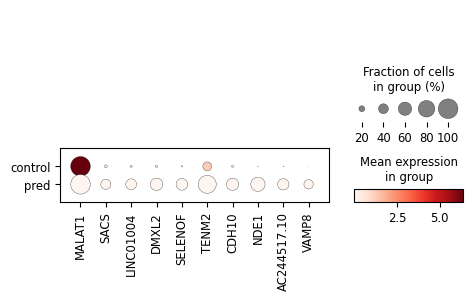

In [ ]:
sc.pl.dotplot(eval_adata, top_genes[0:10], groupby="perturbation")
fig = plt.gcf()
display(fig)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
import numpy as np
import re

def polished_dotplot(df: pd.DataFrame,
                     pval_col='Adjusted P-value',
                     color_col='Combined Score',
                     size_factor=30,
                     title='',
                     top_term=20,
                     cmap='Reds',
                     font_family='DejaVu Sans',
                     font_size=10):

    df = df.copy()

    # Clean pathway codes
    df['Term'] = df['Term'].str.replace(r'\s+\(?(WP|R-HSA)[-_]?\d+\)?$', '', regex=True)

    # Parse overlap
    df[['overlap_hits', 'overlap_total']] = df['Overlap'].str.split('/', expand=True).astype(int)
    df['gene_ratio'] = df['overlap_hits'] / df['overlap_total']
    df['log10_pval'] = -np.log10(df[pval_col])

    # Top N terms
    df_top = df.sort_values('log10_pval', ascending=False).head(top_term)

    # Set global font
    plt.rcParams.update({
        'font.family': font_family,
        'axes.labelsize': font_size + 1,
        'xtick.labelsize': font_size,
        'ytick.labelsize': font_size,
        'axes.titlesize': font_size + 2,
    })

    # Normalize color
    norm = colors.Normalize(vmin=df_top[color_col].min(), vmax=df_top[color_col].max())
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    bar_colors = sm.to_rgba(df_top[color_col])

    # Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    scatter = ax.scatter(
        df_top['log10_pval'],
        df_top['Term'],
        s=df_top['overlap_hits'] * size_factor,
        c=bar_colors,
        cmap=cmap,
        edgecolors='k',
        linewidth=0.5,
        alpha=0.9
    )

    ax.set_xlabel('−log₁₀(Adjusted P-value)')
    ax.set_title(title)
    ax.invert_yaxis()

    # Add colorbar (shrunk)
    cbar = plt.colorbar(sm, ax=ax, fraction=0.035, pad=0.04)
    cbar.set_label(color_col, size=font_size)
    cbar.ax.tick_params(labelsize=font_size - 1)

    plt.tight_layout()
    fig = plt.gcf()
    display(fig)
    return ax


In [ ]:
%pip install gseapy --quiet
import gseapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 597.5/597.5 kB 10.6 MB/s eta 0:00:00


In [ ]:
groups = {
    "Perturbation Signatures": [
        "Disease_Perturbations_from_GEO_down",
        "Disease_Perturbations_from_GEO_up",
    ],

    "Allen Brain" : ["Allen_Brain_Atlas_10x_scRNA_2021",
    "Allen_Brain_Atlas_down",
    "Allen_Brain_Atlas_up"],

    "Phenotype & Disease": [
        "OMIM_Disease",
        "Jensen_DISEASES",
        "Jensen_DISEASES_Curated_2025",
        "Jensen_DISEASES_Experimental_2025",
        "Human_Phenotype_Ontology",
    ],
    "Genetic Association Studies": [
        "GWAS_Catalog_2023",
        "DisGeNET",
    ],
    "Curated Pathways": [
        "Reactome_Pathways_2024",
        "WikiPathways_2024_Human",
    ],
    "Gene Ontology": [
        "GO_Biological_Process_2025",
    ],

    'rummagene/geo': ['RummaGEO_DrugPerturbations_2025',
'RummaGEO_GenePerturbations_2025',
'Rummagene_kinases',
'Rummagene_signatures',
'Rummagene_transcription_factors']


}


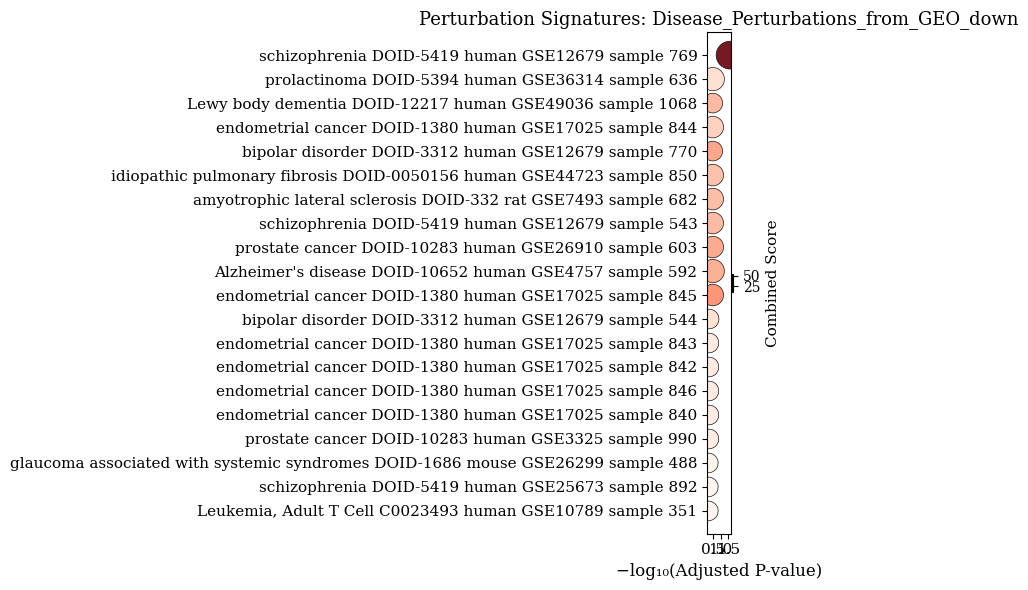

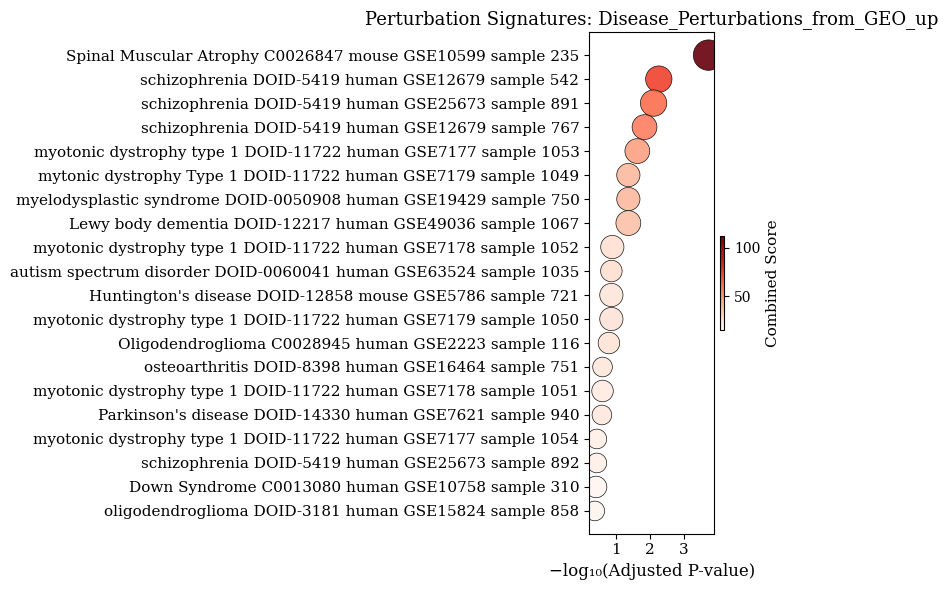

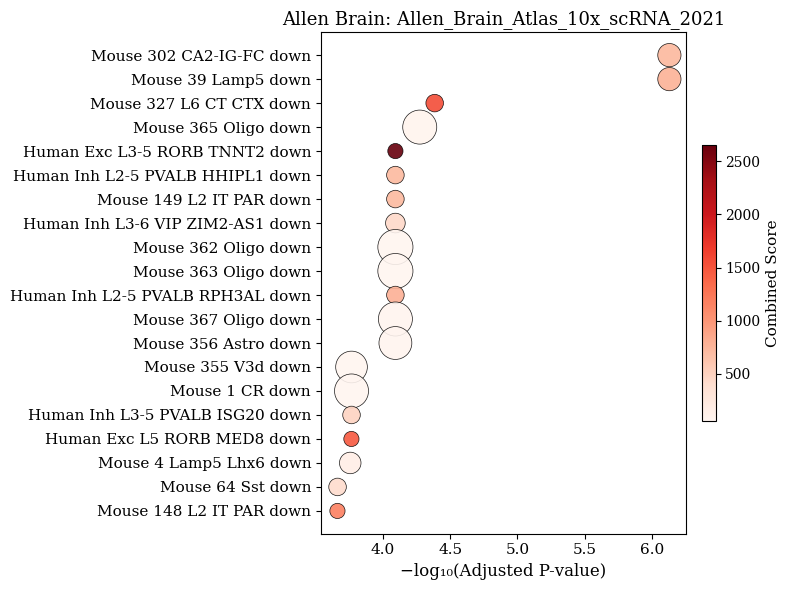

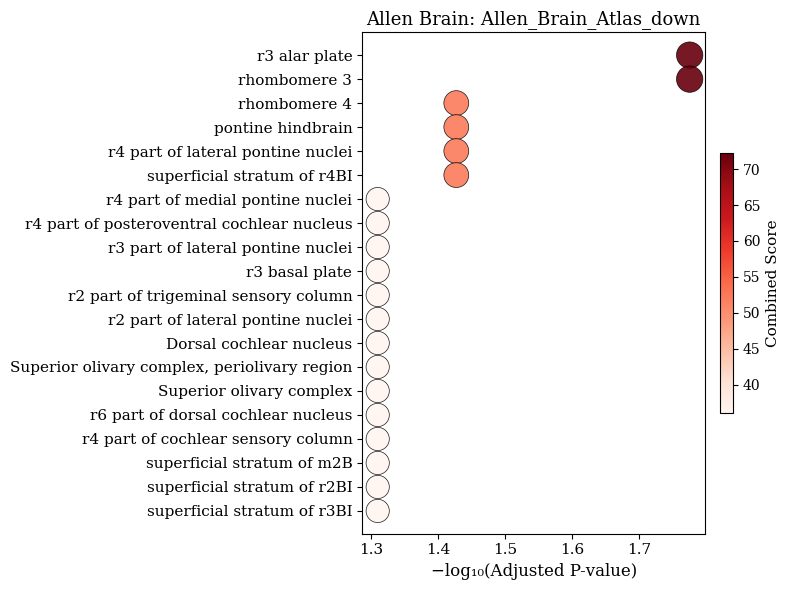

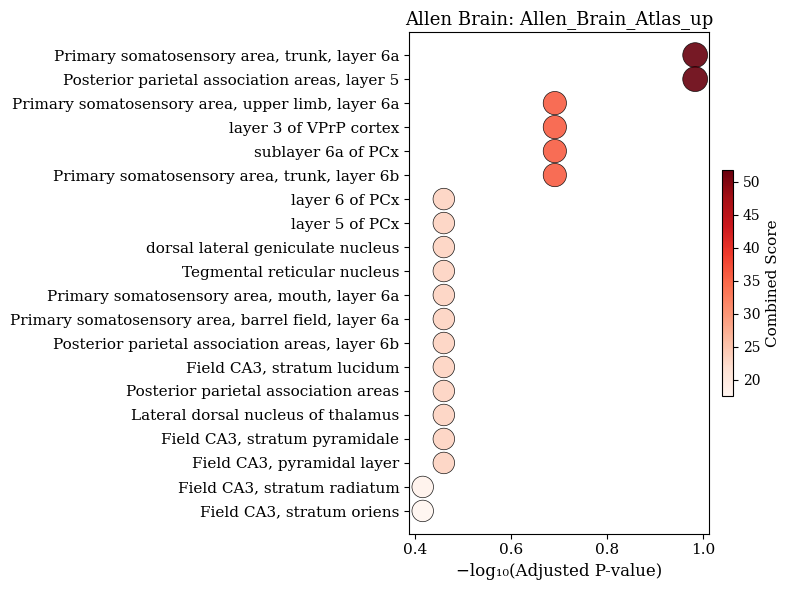

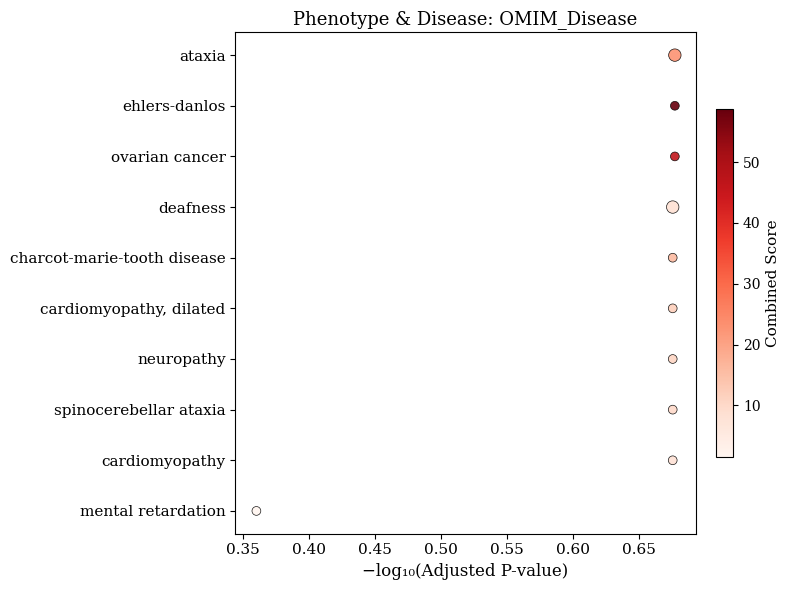

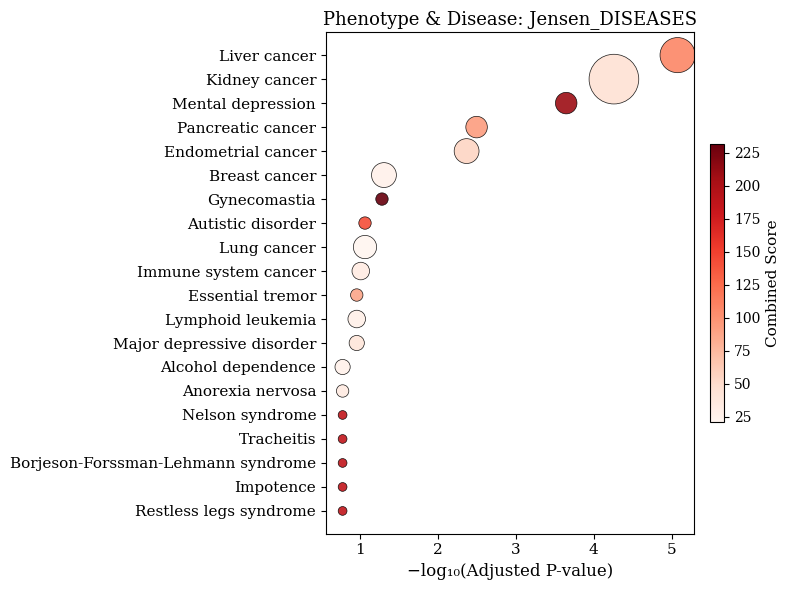

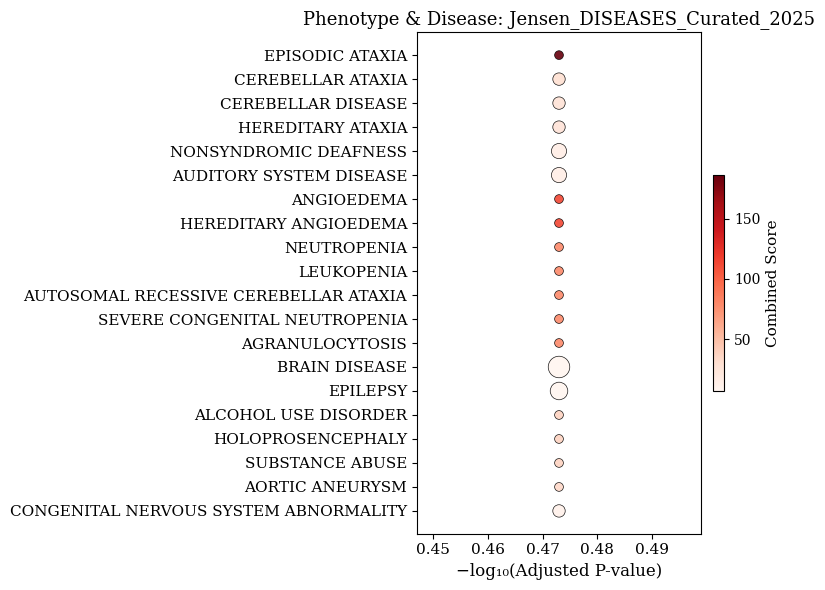

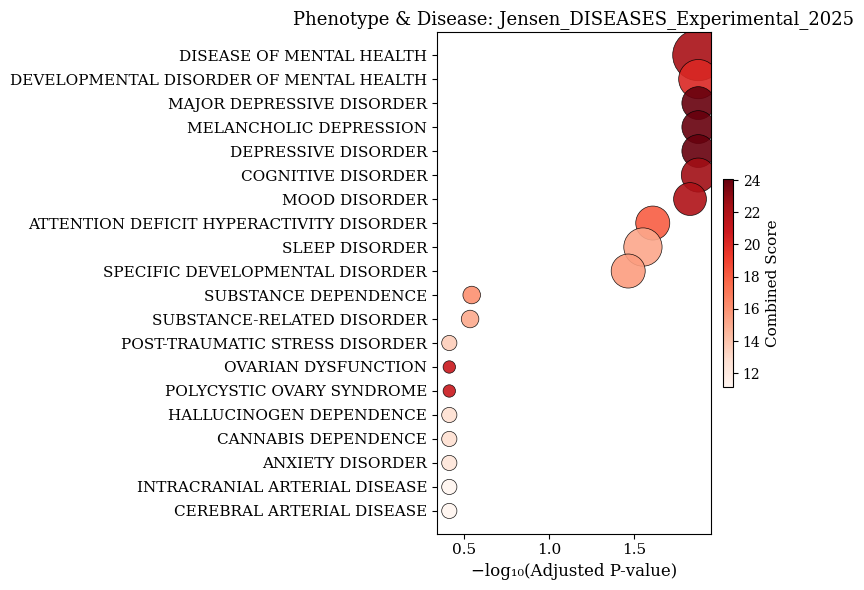

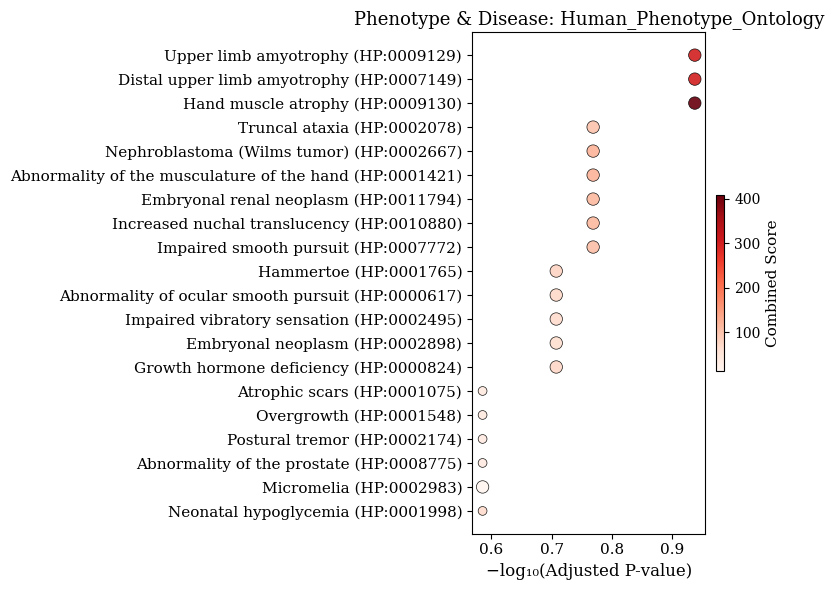

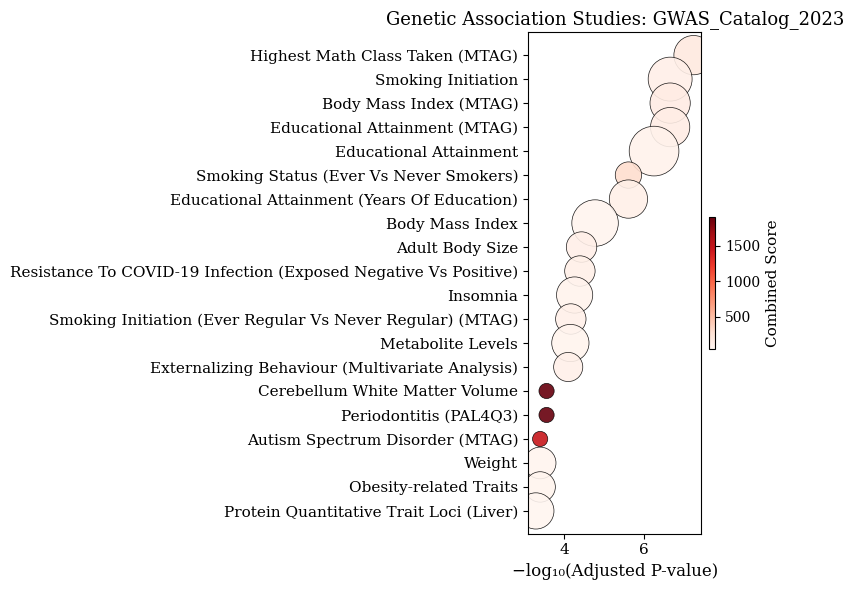

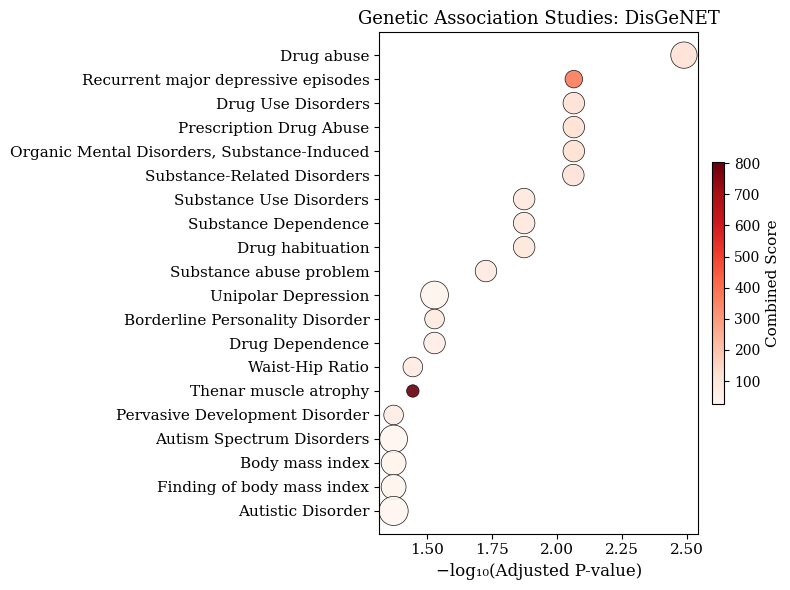

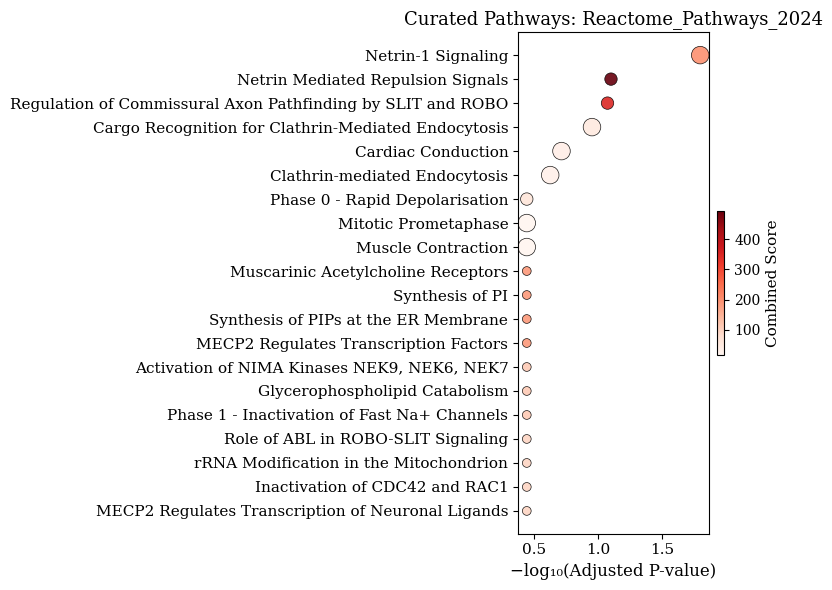

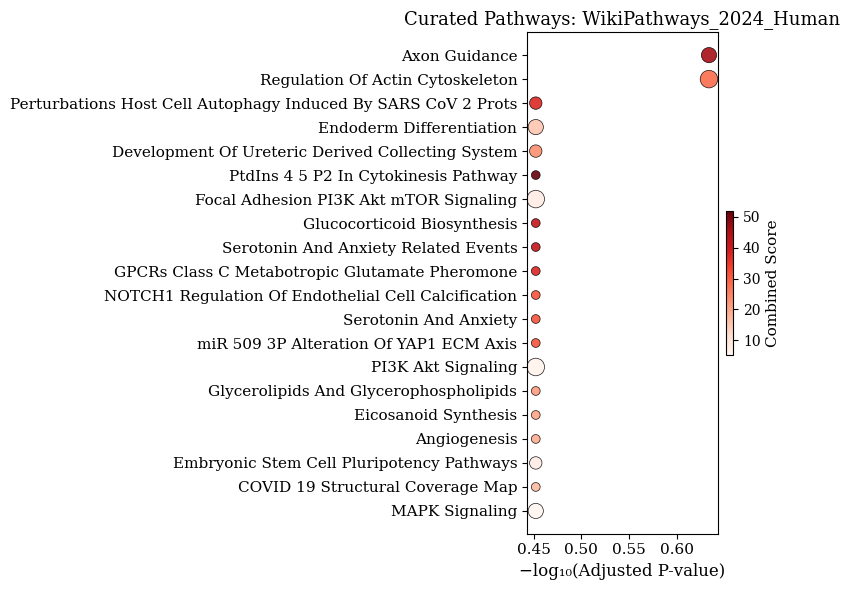

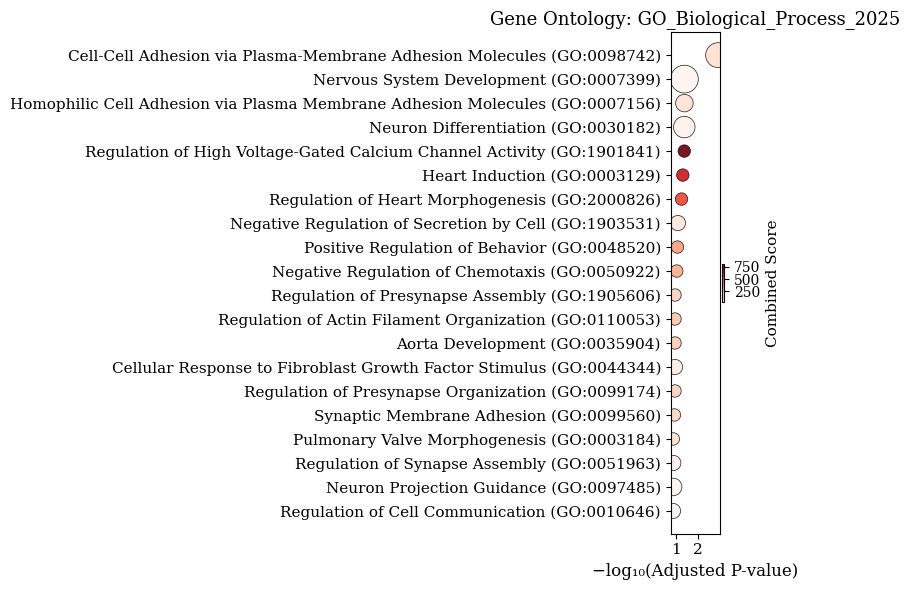

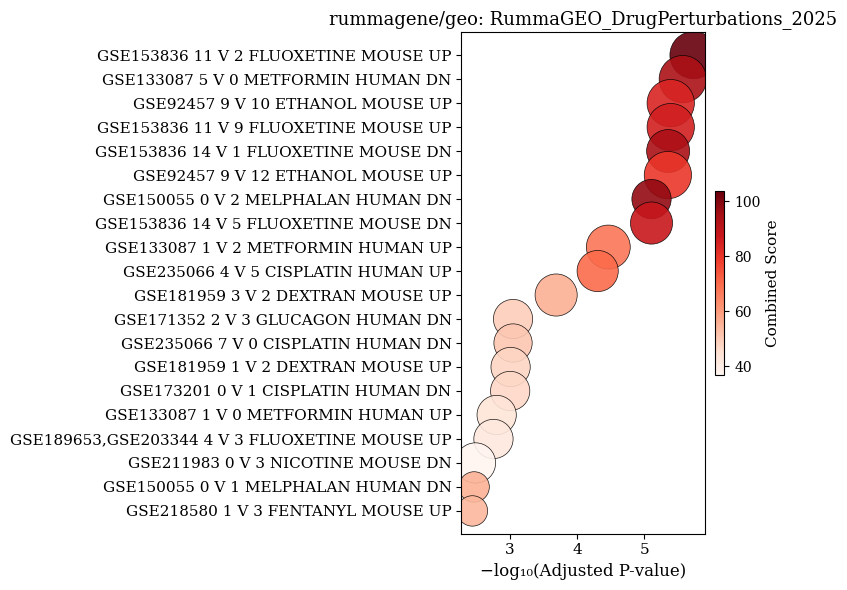

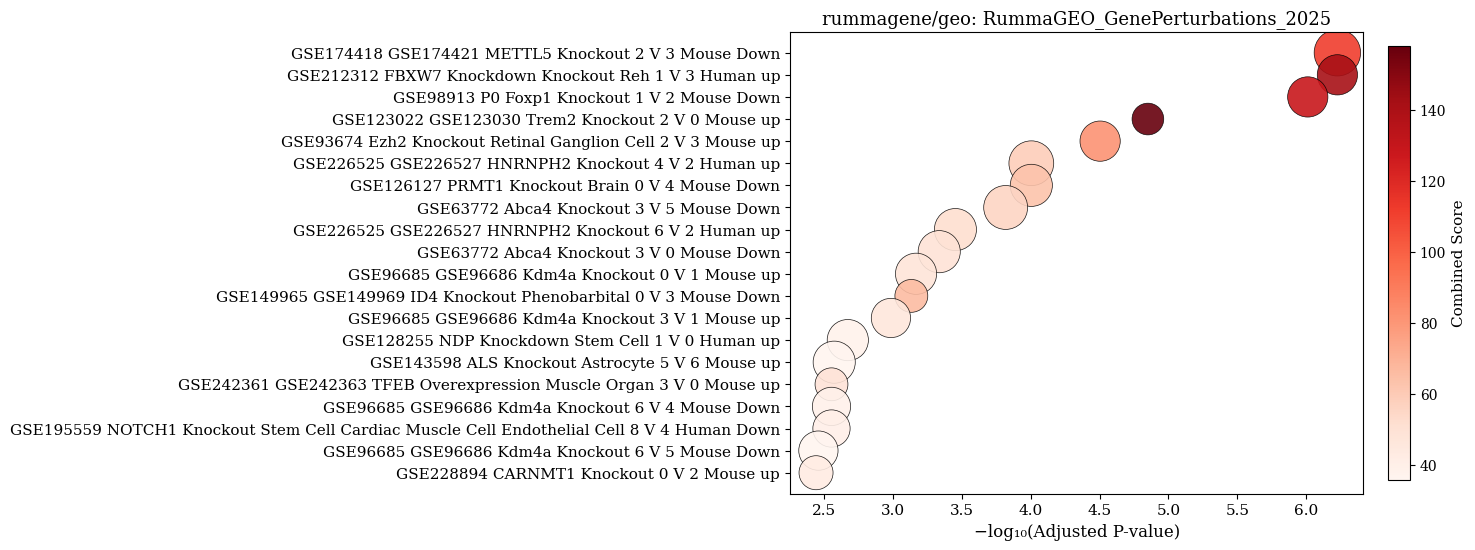

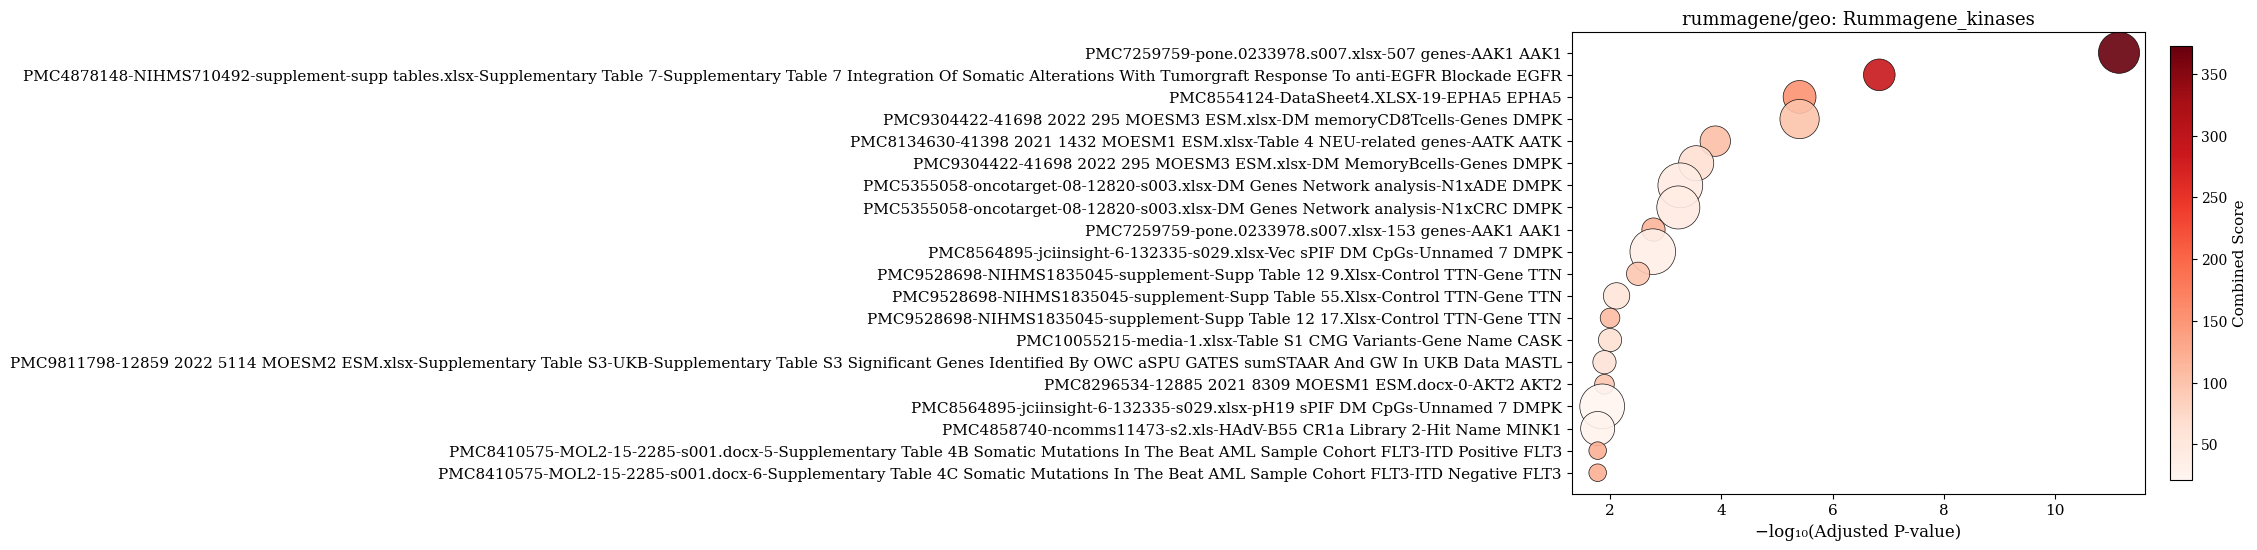

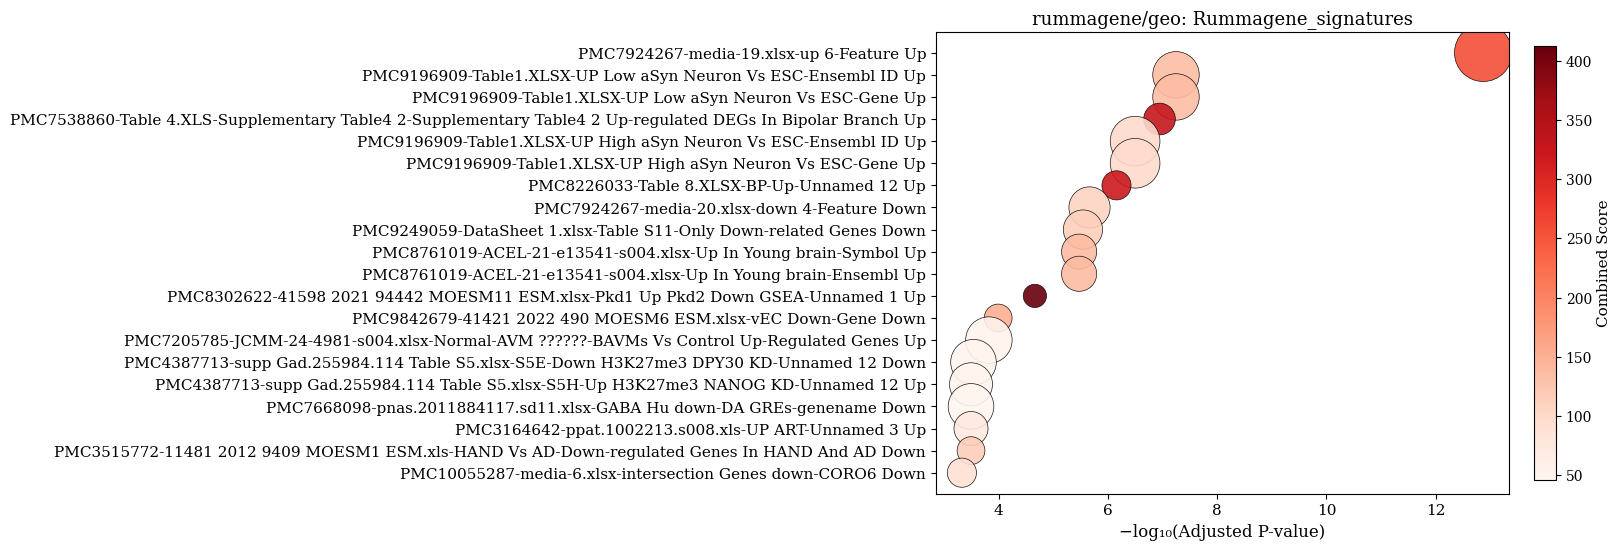

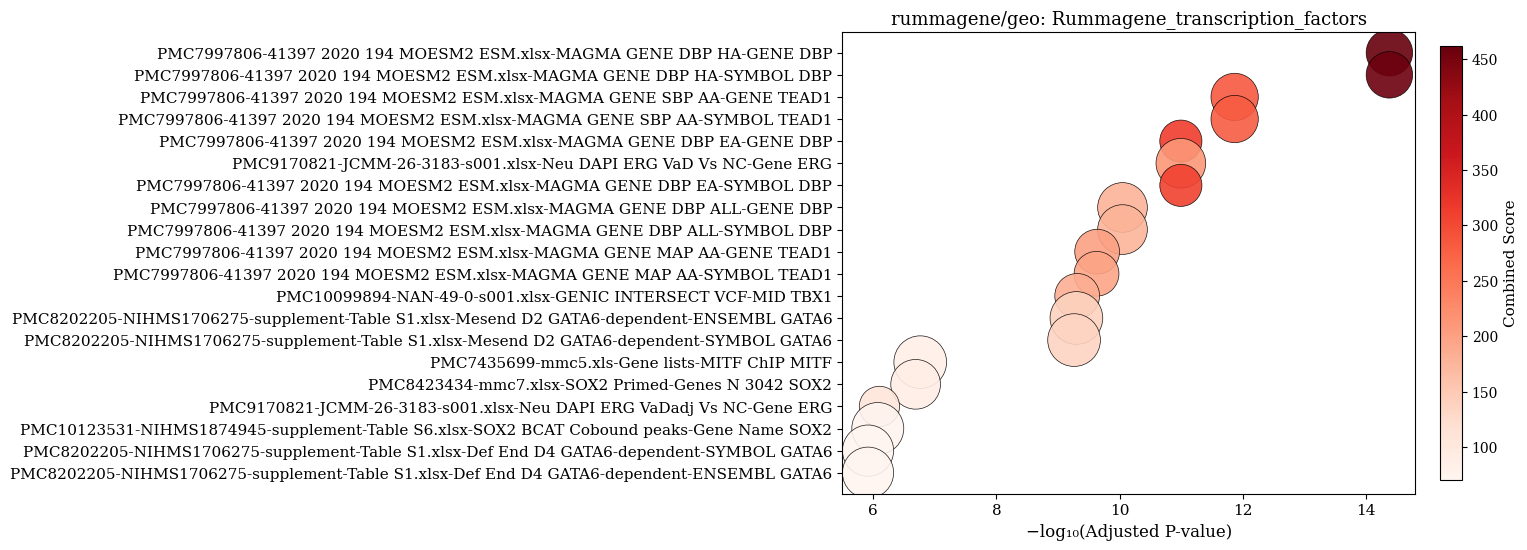

In [ ]:
for group, libs in groups.items():
    for lib in libs:
        try:
            enr = gseapy.enrichr(
                gene_list=top_genes,
                organism="Human",
                gene_sets=lib,
                cutoff=0.05
            )
            if enr.results.empty:
                continue
            polished_dotplot(
                enr.results,
                title=f"{group}: {lib}",
                top_term=20,
                size_factor=40,
                font_family='DejaVu Serif',
                font_size=11
            )
            plt.show()
        except Exception as e:
            print(f"❌ {group} → {lib}: {e}")


In [ ]:
import gseapy
enr_res = gseapy.enrichr(gene_list=top_genes, organism='Human', gene_sets='Disease_Perturbations_from_GEO_up', cutoff = 0.05)
enr_res.results.head()

Gene_set  \
0  Disease_Perturbations_from_GEO_up   
1  Disease_Perturbations_from_GEO_up   
2  Disease_Perturbations_from_GEO_up   
3  Disease_Perturbations_from_GEO_up   
4  Disease_Perturbations_from_GEO_up   

                                                Term Overlap       P-value  \
0  Spinal Muscular Atrophy C0026847 mouse GSE1059...  12/368  3.090040e-07   
1  schizophrenia DOID-5419 human GSE12679 sample 542   9/296  1.767264e-05   
2  schizophrenia DOID-5419 human GSE25673 sample 891   9/326  3.768116e-05   
3  schizophrenia DOID-5419 human GSE12679 sample 767   8/285  9.234117e-05   
4  myotonic dystrophy type 1 DOID-11722 human GSE...   8/316  1.876809e-04   

   Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0          0.000191            0                     0    7.486210   
1          0.005470            0                     0    6.758701   
2          0.007775            0                     0    6.109717   
3          0.014290            0                     0    6.160100   
4          0.023235            0                     0    5.531338   

   Combined Score                                              Genes  
0      112.217632  CHRM2;DSCAM;SGIP1;CDH10;NTM;HECW1;KCNIP4;CACNA...  
1       73.963797  LINGO2;RBFOX1;PCDH9;GPATCH1;TRIAP1;LRP1B;SAC3D...  
2       62.235715  LRFN5;FGF14;HECW1;KCNIP4;CACNA2D3;UNC5C;SAT1;B...  
3       57.227459  RBFOX1;PCDH9;CACNA2D3;GPATCH1;TRIAP1;LRP1B;SNA...  
4       47.463127  STAG2;MORF4L2;SACS;MALAT1;GARS;SMARCA1;CDIPT;SAT1

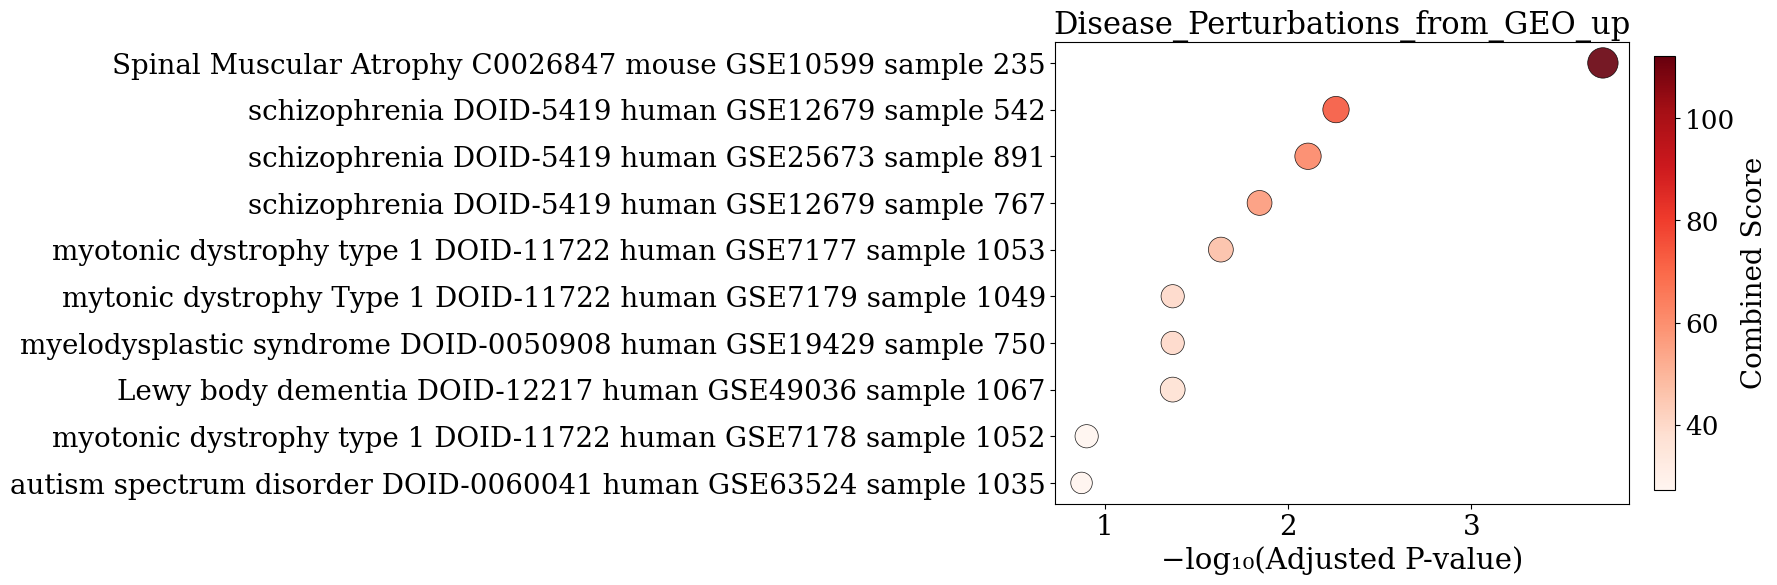

<Axes: title={'center': 'Disease_Perturbations_from_GEO_up'}, xlabel='−log₁₀(Adjusted P-value)'>

In [ ]:
polished_dotplot(
    enr_res.results,
    title='Disease_Perturbations_from_GEO_up',
    top_term=10,
    size_factor=40,          # adjust as needed
    font_family='DejaVu Serif',
    font_size=20
)

In [ ]:
# ─────────────────────────────────────────────
# EXTRA: Isolate Parkinson's-related enrichments
# ─────────────────────────────────────────────

parkinson_terms = []
keywords = ['alpha-synuclein', 'SNCA', 'Lewy body',
    'mitochondrial dysfunction', 'PINK1', 'parkin', 'PRKN',
    'oxidative stress', 'ROS', 'ubiquitin-proteasome', 'autophagy',
    'neuroinflammation', 'microglial activation', 'ferroptosis',
    'LRRK2', 'Rab GTPase', 'MAPK signaling', 'PI3K-Akt', 'mTOR',
    'apoptosis', 'caspase', 'calcium signaling',
    'gut-brain axis', 'dopaminergic synapse', 'BDNF', 'GDNF',
    'NMDA receptor', 'GABA receptor'
]

for group, libs in groups.items():
    for lib in libs:
        try:
            enr = gseapy.enrichr(
                gene_list=top_genes,
                organism="Human",
                gene_sets=lib,
                cutoff=0.05
            )
            if enr.results.empty:
                continue

            # Filter for Parkinson's-related terms
            df = enr.results.copy()
            df['Library'] = lib
            df['Group'] = group

            df_filtered = df[df['Term'].str.lower().str.contains('|'.join(keywords))]
            if not df_filtered.empty:
                parkinson_terms.append(df_filtered)
        except Exception as e:
            print(f"❌ {group} → {lib}: {e}")

# Concatenate all Parkinson-related results
if parkinson_terms:
    parkinson_df = pd.concat(parkinson_terms, ignore_index=True)
    display(parkinson_df[['Term', 'P-value', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Library', 'Group']])
else:
    print("🧠 No Parkinson's-related terms found in current results.")


Term   P-value  \
0   Parkinson's disease DOID-14330 human GSE7621 s...  0.370544   
1   Parkinson's disease DOID-14330 human GSE19587 ...  0.541416   
2   Parkinson's disease DOID-14330 human GSE19587 ...  0.568546   
3   Parkinson's disease DOID-14330 human GSE19587 ...  0.651865   
4   Parkinson's disease DOID-14330 human GSE7621 s...  0.006544   
5   Parkinson's disease DOID-14330 human GSE7621 s...  0.028626   
6   Parkinson's disease DOID-14330 human GSE19587 ...  0.134312   
7   Parkinson's disease DOID-14330 human GSE19587 ...  0.336152   
8   Parkinson's disease DOID-14330 human GSE19587 ...  0.368462   
9   Parkinson's disease DOID-14330 human GSE6613 s...  0.398966   
10  Parkinson's disease DOID-14330 human GSE19587 ...  0.548470   
11          Parkinson Disease And Lewy Body Pathology  0.029631   
12            Parkinson's Disease Progression (Motor)  0.029631   
13  Parkinson's Disease Motor Subtype (Tremor To P...  0.063103   
14                             Parkinsonian Disorders  0.659877   
15                                  Parkinson Disease  0.906562   
16                     SARS-CoV-2 Modulates Autophagy  0.067791   
17  Perturbations Host Cell Autophagy Induced By S...  0.020429   
18  Neuroinflammation And Glutamatergic Signaling ...  0.155166   
19                                 Ferroptosis WP4313  0.278439   
20                        Macroautophagy (GO:0016236)  0.047728   
21  Regulation of Autophagy of Mitochondrion (GO:1...  0.086310   
22            Autophagy of Mitochondrion (GO:0000422)  0.263779   
23               Regulation of Autophagy (GO:0010506)  0.686373   
24  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.070310   
25  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.086376   
26  PMC5364060-NIHMS808256-supplement-supp table1....  0.152569   
27  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.152569   
28  PMC3564263-msb201265-s7.xls-Up-regulated genes...  0.169420   
29  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.514110   
30  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.555263   
31  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.572886   
32  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.604087   
33  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.684778   
34  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.738260   
35  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.788536   
36  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.826141   
37  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.954955   
38  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.067791   
39  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.086310   
40  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...  0.104465   
41  PMC10248509-Data Sheet 5.CSV--GSE58294 DE-gene...  0.136164   
42  PMC3661531-pone.0064691.s006.xlsx-Sheet1-Table...  0.144017   
43  PMC10248509-Data Sheet 6.CSV--GSE58294 DE-gene...  0.168682   
44  PMC10248509-Data Sheet 6.CSV--GSE58294 DE-gene...  0.174572   
45  PMC6151027-12864 2018 5080 MOESM6 ESM.xlsx-Oxi...  0.225827   
46  PMC3799442-supp Gkt678 nar-01667-h-2013-File01...  0.453948   
47  PMC4367834-12864 2014 6889 MOESM9 ESM.xlsx-Net...  0.833943   
48  PMC10248509-Data Sheet 5.CSV--GSE66724 DE-Gene...  0.889129   
49  PMC10248509-Data Sheet 6.CSV--GSE58294 DE-gene...  0.914197   

    Adjusted P-value  Combined Score Overlap  \
0           0.878240        1.554707   2/258   
1           0.878240        0.681582   2/361   
2           0.878240        0.678061   1/167   
3           0.878240        0.386238   2/442   
4           0.253189       22.636872   5/235   
5           0.571603       10.856744   5/342   
6           0.893555        4.195589   4/393   
7           0.893555        1.845899   2/239   
8           0.893555        1.398169   3/433   
9           0.893555        1.353224   2/274   
10          0.893555        0.762923   1/158   
11          0.085978      141.432767     1/6   
12     

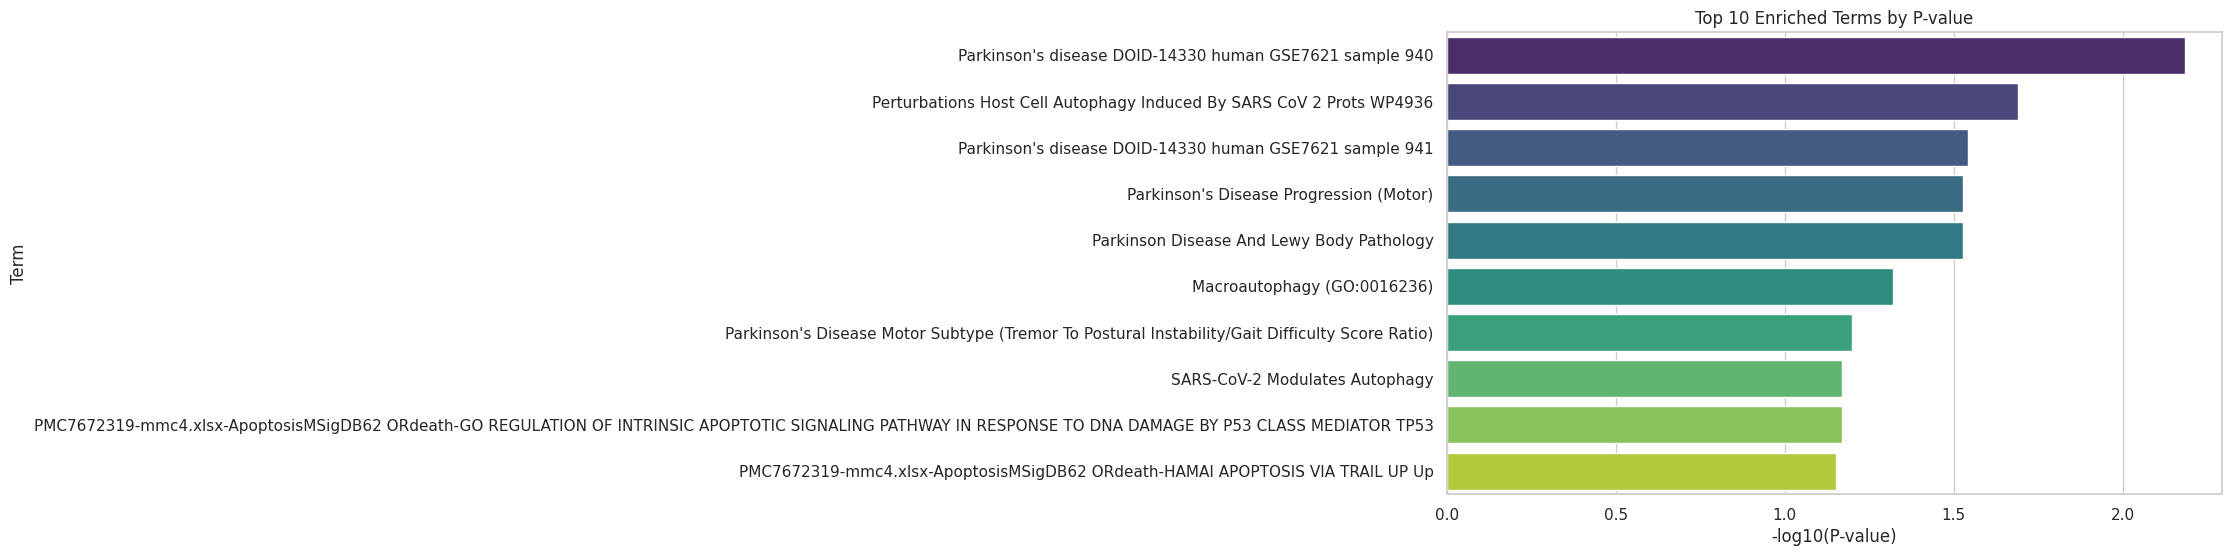

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sort by P-value and select top 10
top_terms = parkinson_df.sort_values('P-value').head(10).copy()
top_terms["-log10(P-value)"] = -np.log10(top_terms["P-value"])

# Ensure terms are ordered by significance
top_terms = top_terms.sort_values("P-value", ascending=True)
order = top_terms["Term"]

# Set plot style
sns.set(style="whitegrid")

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    x='-log10(P-value)',
    y='Term',
    data=top_terms,
    palette='viridis',
    order=order
)

plt.title('Top 10 Enriched Terms by P-value')
plt.xlabel('-log10(P-value)')
plt.ylabel('Term')
plt.tight_layout()
fig = plt.gcf()
display(fig)

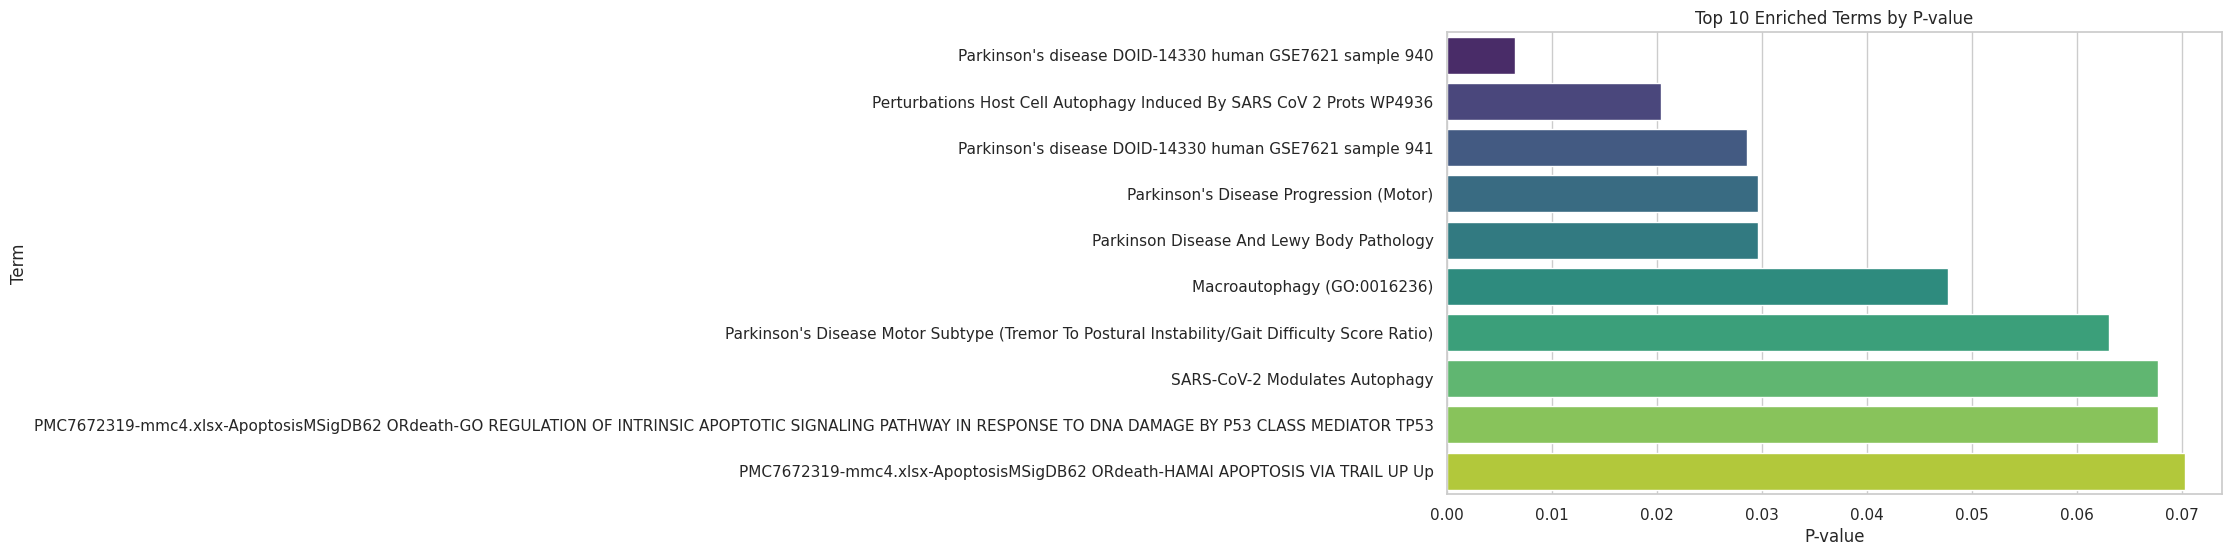

In [ ]:
# Sort by P-value and select top 10
top_terms = parkinson_df.sort_values('P-value').head(10)

# Set plot style
sns.set(style="whitegrid")

# Create horizontal bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='P-value', y='Term', data=top_terms, palette='viridis')
plt.title('Top 10 Enriched Terms by P-value')
plt.xlabel('P-value')
plt.ylabel('Term')
plt.tight_layout()
fig = plt.gcf()
display(fig)

Gene_set  \
4   Disease_Perturbations_from_GEO_up   
17            WikiPathways_2024_Human   
5   Disease_Perturbations_from_GEO_up   
12                  GWAS_Catalog_2023   
11                  GWAS_Catalog_2023   
20         GO_Biological_Process_2025   
13                  GWAS_Catalog_2023   
16             Reactome_Pathways_2024   
38    Rummagene_transcription_factors   
24               Rummagene_signatures   

                                                 Term Overlap   P-value  \
4   Parkinson's disease DOID-14330 human GSE7621 s...   5/235  0.006544   
17  Perturbations Host Cell Autophagy Induced By S...    2/44  0.020429   
5   Parkinson's disease DOID-14330 human GSE7621 s...   5/342  0.028626   
12            Parkinson's Disease Progression (Motor)     1/6  0.029631   
11          Parkinson Disease And Lewy Body Pathology     1/6  0.029631   
20                        Macroautophagy (GO:0016236)   3/162  0.047728   
13  Parkinson's Disease Motor Subtype (Tremor To P...    1/13  0.063103   
16                     SARS-CoV-2 Modulates Autophagy    1/14  0.067791   
38  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...    1/14  0.067791   
24  PMC7672319-mmc4.xlsx-ApoptosisMSigDB62 ORdeath...   6/579  0.070310   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
4           0.253189            0                     0    4.501144   
17          0.352964            0                     0    9.649174   
5           0.571603            0                     0    3.055287   
12          0.085978            0                     0   40.191919   
11          0.085978            0                     0   40.191919   
20          0.219465            0                     0    3.839914   
13          0.120120            0                     0   16.740741   
16          0.360525            0                     0   15.452214   
38          0.468526            0                     0   15.452214   
24          0.626303            0                     0    2.152946   

    Combined Score                              Genes  \
4        22.636872      RBFOX1;PCDH9;CRH;MALAT1;OPCML   
17       37.542776                        VAMP8;VPS39   
5        10.856744           CBR1;PCDH9;NTM;GPBP1;SRI   
12      141.432767                              THSD4   
11      141.432767                             KCNIP4   
20       11.681905               VAMP8;VPS39;NIPSNAP2   
13       46.254339                              OPCML   
16       41.586959                              VPS39   
38       41.586959                             TRIAP1   
24        5.715737  CEP57;STAG2;SACM1L;RDX;SACS;ESRRG   

                              Library                        Group  
4   Disease_Perturbations_from_GEO_up      Perturbation Signatures  
17            WikiPathways_2024_Human             Curated Pathways  
5   Disease_Perturbations_from_GEO_up      Perturbation Signatures  
12                  GWAS_Catalog_2023  Genetic Association Studies  
11                  GWAS_Catalog_2023  Genetic Association Studies  
20         GO_Biological_Process_2025                Gene Ontology  
13                  GWAS_Catalog_2023  Genetic Association Studies  
16             Reactome_Pathways_2024             Curated Pathways  
38    Rummagene_transcription_factors                rummagene/geo  
24               Rummagene_signatures                rummagene/geo

                         Gene_set                                                                                                                                                       Term Overlap  P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  Combined Score                             Genes                           Library                       Group
Disease_Perturbations_from_GEO_up                                                                                                    Parkinson's disease DOID-14330 human GSE7621 sample 940   5/235 0.006544          0.253189            0                     0    4.501144       22.636872     RBFOX1;PCDH9;CRH;MALAT1;OPCML Disease_Perturbations_from_GEO_up     Perturbation Signatures
          WikiPathways_2024_Human                                                                                       Perturbations Host Cell Autophagy Induced By SARS CoV 2 Prots WP4936    2/44 0.020429          0.352964           

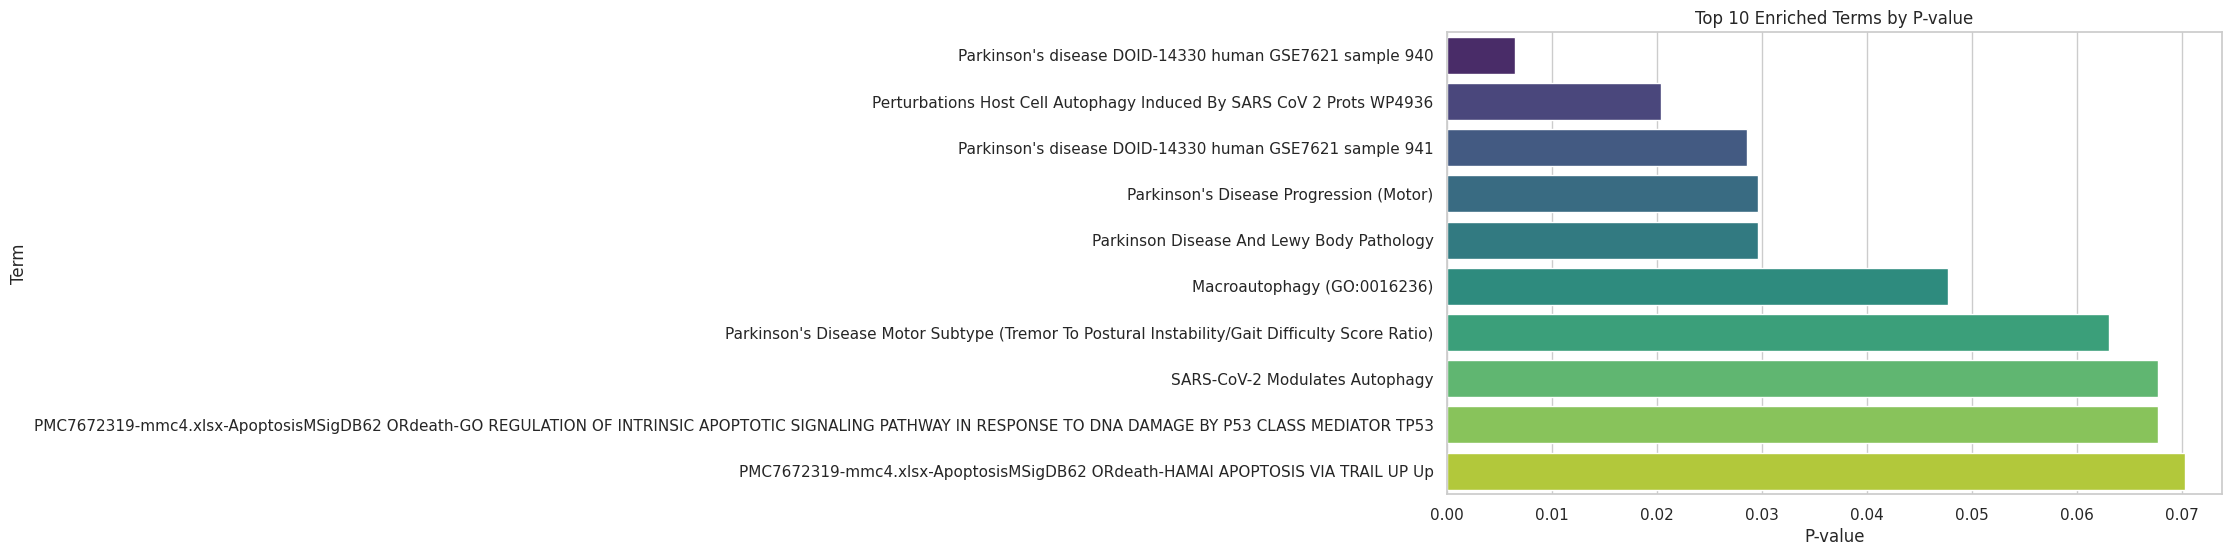

In [ ]:
# Sort by P-value and select top 10
top_terms = parkinson_df.sort_values('P-value').head(10)

# Display as a table
from IPython.display import display
display(top_terms)  # shows a nice HTML table in Jupyter/Colab

# Or, if you want a plain text table in console:
print(top_terms.to_string(index=False))

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='P-value', y='Term', data=top_terms, palette='viridis')
plt.title('Top 10 Enriched Terms by P-value')
plt.xlabel('P-value')
plt.ylabel('Term')
plt.tight_layout()
fig = plt.gcf()
display(fig)